<a href="https://colab.research.google.com/github/manishkumar-dsi/finding-order-in-chaos/blob/master/deep-learning-practice/TransferLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Transfer learning using Tensorflow hub
# For this we need a specific version of tensorflow and tensorflow hub
#!pip install "tf-nightly-gpu"
#!pip install "tensorflow_hub==0.4.0"

In [0]:
from __future__ import absolute_import, division, print_function

import matplotlib.pyplot as plt
import tensorflow as tf
# tf.logging.set_verbosity(tf.logging.ERROR)
# tf.enable_eager_execution()

import tensorflow_hub as hub
import tensorflow_datasets as tfds

from tensorflow.keras import layers


In [0]:
# Part 1: Use MobileNet for prediction
CLASSIFIER_URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2"
IMAGE_RES = 224

model = tf.keras.Sequential([
                             hub.KerasLayer(CLASSIFIER_URL, input_shape=(IMAGE_RES, IMAGE_RES, 3))
])

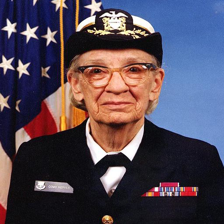

In [11]:
# run it on single image
import numpy as np
import PIL.Image as Image

grace_hopper = tf.keras.utils.get_file('image.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg')
grace_hopper = Image.open(grace_hopper).resize((IMAGE_RES, IMAGE_RES))
grace_hopper

In [13]:
grace_hopper = np.array(grace_hopper)/255.0
grace_hopper.shape

(224, 224, 3)

In [14]:
# Here we are adding one dimension to the grace_hopper image using np.newaxis
# A nice artical to understand use of np.newaxis (https://medium.com/@ian.dzindo01/what-is-numpy-newaxis-and-when-to-use-it-8cb61c7ed6ae)
# This extra dimension is the batch dimension, model.predict always require batch dimention.
result = model.predict(grace_hopper[np.newaxis, ...])
result.shape
# Predicted result (1, 1001)
# Here 1001 is the prediction probability distribution.
# Since we are use MobileNet and it usage 1000 classes so 1 image prediction is distributed among 1000 classes

(1, 1001)

In [19]:
predict_class= np.argmax(result[0], axis=-1)
predict_class

653

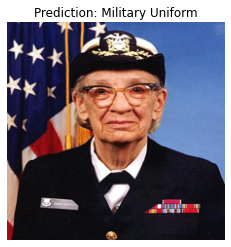

In [21]:
# Decode the prediction
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

plt.imshow(grace_hopper)
plt.axis('off')
predicted_class_name = imagenet_labels[predict_class]
_=plt.title("Prediction: " + predicted_class_name.title())

In [0]:
#Part 2: Use Tensorflow Hub models for the Cats vs Dogs dataset

In [0]:
# ref: https://stackoverflow.com/questions/59195322/cannot-split-malaria-dataset-using-tensorflow-datasets
splits = tfds.Split.ALL.subsplit(weighted=(80, 20))
(train_examples, validation_examples, test_examples), info = tfds.load('cats_vs_dogs', with_info=True, as_supervised=True, split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'])
#(train_examples, validation_examples) = splits

num_examples = info.splits['train'].num_examples
num_classes = info.features['label'].num_classes

In [41]:
# All image do not have same size
for i, example_image in enumerate(train_examples.take(3)):
  print("Image {} shape: {}".format(i+1, example_image[0].shape))

Image 1 shape: (262, 350, 3)
Image 2 shape: (409, 336, 3)
Image 3 shape: (493, 500, 3)


In [0]:
# So let's reformat the image resolution to (224, 224)

def format_image(image, label):
  image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))/255.0
  return image, label

BATCH_SIZE = 32
train_batches = train_examples.shuffle(num_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_examples.map(format_image).batch(BATCH_SIZE).prefetch(1)

In [43]:
# Run the classifier on batch of images
image_batch, label_batch = next(iter(train_batches.take(1)))
image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

result_batch = model.predict(image_batch)

predicted_class_names = imagenet_labels[np.argmax(result_batch, axis=-1)]
predicted_class_names

array(['Border collie', 'beagle', 'crossword puzzle', 'kelpie',
       'tiger cat', 'Egyptian cat', 'tiger cat', 'malinois',
       'German shepherd', 'Labrador retriever', 'tiger cat',
       'Boston bull', 'Persian cat', 'Siberian husky', 'Egyptian cat',
       'doormat', 'tabby', 'Egyptian cat', 'tabby', 'chow',
       'Labrador retriever', 'tabby', 'Persian cat', 'bucket', 'bluetick',
       'tabby', 'Siamese cat', 'miniature pinscher', 'Egyptian cat',
       'English springer', 'pug', 'tiger cat'], dtype='<U30')

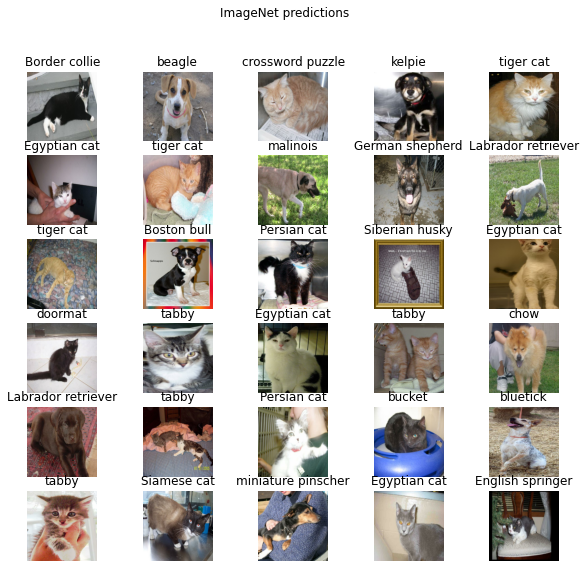

In [45]:
# Plot the image
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6, 5, n+1)
  plt.imshow(image_batch[n])
  plt.title(predicted_class_names[n])
  plt.axis('off')
_=plt.suptitle("ImageNet predictions")

In [0]:
# Part 3: Transfer learning with Tesorflow hub
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2"
feature_extractor = hub.KerasLayer(URL, input_shape=(IMAGE_RES, IMAGE_RES, 3))

In [0]:
feature_extractor.trainable = False

In [48]:
# Attach classification head
model = tf.keras.Sequential([
                             feature_extractor,
                             layers.Dense(2, activation='softmax')
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


In [52]:
# Train model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
EPOCHS = 6
history = model.fit(train_batches,
                    epochs = EPOCHS,
                    validation_data = validation_batches)

Epoch 1/6
582/582 [==============================] - 37s 63ms/step - loss: 0.0156 - accuracy: 0.9954 - val_loss: 0.0436 - val_accuracy: 0.9867
Epoch 2/6
582/582 [==============================] - 37s 64ms/step - loss: 0.0141 - accuracy: 0.9960 - val_loss: 0.0432 - val_accuracy: 0.9875
Epoch 3/6
582/582 [==============================] - 37s 63ms/step - loss: 0.0128 - accuracy: 0.9962 - val_loss: 0.0443 - val_accuracy: 0.9871
Epoch 4/6
582/582 [==============================] - 36s 61ms/step - loss: 0.0111 - accuracy: 0.9970 - val_loss: 0.0468 - val_accuracy: 0.9880
Epoch 5/6
582/582 [==============================] - 37s 64ms/step - loss: 0.0099 - accuracy: 0.9972 - val_loss: 0.0457 - val_accuracy: 0.9867
Epoch 6/6
582/582 [==============================] - 37s 63ms/step - loss: 0.0103 - accuracy: 0.9972 - val_loss: 0.0473 - val_accuracy: 0.9884


In [51]:
# plot graph accuracy vs loss

acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize = (8, 8))
plt.subplot(1,2,1)
plt.plot(epochs_range, val_acc, label='Training Accuracy')
plt.title('Training and Validation accuracy')

plt.subplot(1,2,2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation loss')
plt.show()

KeyError: ignored